In [70]:
from PointNet2FPUNet import *
import numpy as np
from sklearn.cluster import MeanShift, estimate_bandwidth
import plotly.express as px
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import pickle
from sklearn.cluster import AgglomerativeClustering

In [71]:
def normalize_embeddings(embeddings):
    """
    Normalize embeddings to unit L2 norm per point.
    Input: embeddings (N, D)
    Output: normalized (N, D)
    """
    norms = np.linalg.norm(embeddings, axis=1, keepdims=True) + 1e-8
    return embeddings / norms

In [90]:
def inference_on_point_cloud(model, point_cloud, device='cuda', clustering='meanshift'):
    """
    Args:
        model: trained PointNet++ U-Net model
        point_cloud: (N, 3) numpy array of point cloud
        clustering: 'meanshift' or 'dbscan'
    Returns:
        predicted_labels: (N,) instance labels
        embeddings: (N, D) per-point feature embeddings
    """
    model.eval()
    point_cloud_tensor = torch.tensor(point_cloud, dtype=torch.float32).unsqueeze(0).to(device)  # (1, N, 3)

    with torch.no_grad():
        pe = add_positional_encoding(point_cloud_tensor)  # (1, N, 6)
        embeddings, skip = model.encoder(point_cloud_tensor, return_skips=True)  # (1, N, D)
        embeddings = embeddings.squeeze(0).cpu().numpy()  # → (N, D)
        embeddings = normalize_embeddings(embeddings)

    # Clustering
    if clustering == 'meanshift':
        bandwidth = estimate_bandwidth(embeddings, quantile=0.1)
        # clustering = MeanShift(bandwidth=bandwidth, bin_seeding=True).fit(embeddings)
        try:
            clustering = MeanShift(bandwidth=bandwidth, bin_seeding=True).fit(embeddings)
        except ValueError as e:
            print("Falling back to bin_seeding=False due to error:", e)
            clustering = MeanShift(bandwidth=bandwidth, bin_seeding=False).fit(embeddings)
    elif clustering == 'dbscan':
        from sklearn.cluster import DBSCAN
        clustering = DBSCAN(eps=2, min_samples=5).fit(embeddings)
    elif clustering == 'agglomerative':
        clustering = AgglomerativeClustering(n_clusters=None, distance_threshold=1.0).fit(embeddings)
    else:
        raise ValueError("Clustering method must be 'meanshift', 'dbscan', or 'agglomerative'.")

    predicted_labels = clustering.labels_  # shape: (N,)
    return predicted_labels, embeddings


In [73]:
def filter_clusters(labels, min_cluster_size=20):
    """
    Removes small clusters by relabeling them as -1 (noise).
    """
    labels = np.array(labels)
    final_labels = labels.copy()
    for cluster_id in np.unique(labels):
        if cluster_id == -1:
            continue
        mask = labels == cluster_id
        if np.sum(mask) < min_cluster_size:
            final_labels[mask] = -1
    return final_labels


In [74]:
def load_clean_point_cloud(file_path, max_points=512):
    """
    Reads a point cloud file, removes non-numeric lines, and ensures exactly 128 points.
    
    Args:
        file_path (str): Path to the .txt file containing point cloud data.
        max_points (int): Fixed number of points per cloud (default: 128).
    
    Returns:
        numpy array: (128, 3) shape point cloud with valid XYZ values.
    """
    valid_points = []

    with open(file_path, "r") as file:
        for line in file:
            try:
                # Convert to float, handling both spaces & commas as delimiters
                values = np.array(line.strip().replace(',', ' ').split(), dtype=np.float64)
                if len(values) == 3:  # Ensure it's an (X, Y, Z) point
                    valid_points.append(values)
            except ValueError:
                continue  # Skip invalid lines

    valid_points = np.array(valid_points)

    num_points = valid_points.shape[0]

    if num_points > max_points:
        # Subsample to 128 points randomly
        indices = np.random.choice(num_points, max_points, replace=False)
        valid_points = valid_points[indices]
    elif num_points < max_points:
        # Pad with zeros to reach 128 points
        pad_size = max_points - num_points
        pad_points = np.zeros((pad_size, 3), dtype=np.float64)
        valid_points = np.vstack((valid_points, pad_points))

    return valid_points

In [75]:
def visualize_embeddings(embeddings, labels=None, method='pca'):
    """
    Visualize 2D projection of embeddings via PCA or t-SNE.
    """
    if method == 'pca':
        reducer = PCA(n_components=2)
    elif method == 'tsne':
        reducer = TSNE(n_components=2, perplexity=30)
    else:
        raise ValueError("Method must be 'pca' or 'tsne'.")

    projected = reducer.fit_transform(embeddings)

    plt.figure(figsize=(8, 6))
    if labels is not None:
        plt.scatter(projected[:, 0], projected[:, 1], c=labels, cmap='jet', s=3)
    else:
        plt.scatter(projected[:, 0], projected[:, 1], s=3)
    plt.title(f'Embedding Projection ({method.upper()})')
    plt.axis('off')
    plt.tight_layout()
    plt.show()

In [76]:
def visualize_clusters_plotly(points, labels, title="3D Instance Segmentation"):
    """
    Plot point cloud with instance labels using Plotly.
    Args:
        points: (N, 3)
        labels: (N,) array of ints
    """
    df = pd.DataFrame(points, columns=['x', 'y', 'z'])
    df['label'] = labels.astype(str)

    fig = px.scatter_3d(df, x='x', y='y', z='z', color='label',
                        title=title,
                        size_max=1, opacity=0.8)
    fig.update_traces(marker=dict(size=2))
    fig.update_layout(scene=dict(xaxis_visible=False, yaxis_visible=False, zaxis_visible=False))
    fig.show()


In [77]:
def plot_loss_from_pkl(pkl_path):
    with open(pkl_path, 'rb') as f:
        loss_history = pickle.load(f)

    plt.figure(figsize=(8, 5))
    plt.plot(loss_history, marker='o', linewidth=2)
    plt.title("Training Loss Over Epochs")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

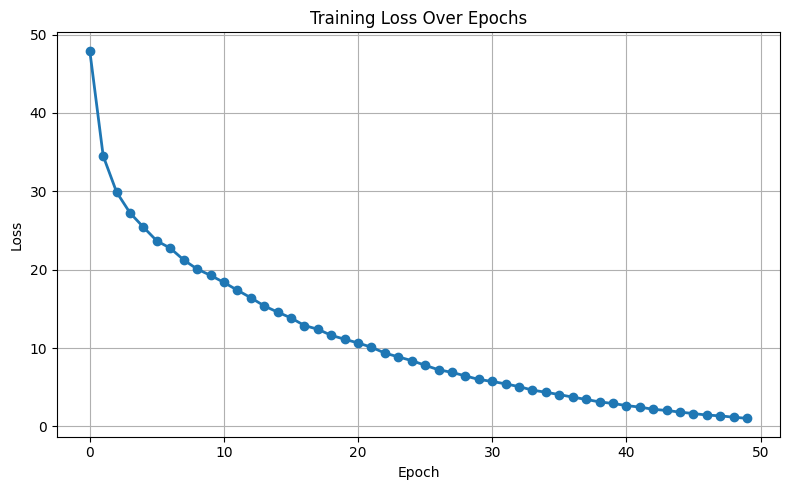

In [78]:
plot_loss_from_pkl("model/loss_history_pointnetpp_unet.pkl")

In [79]:
# Initialize model
device = torch.device("cuda" if torch.cuda.is_available() else "mps")
model = PointNetPPUNet(emb_dim=128, output_dim=64).to(device)

# Load trained weights
model.load_state_dict(torch.load("model/pointnetpp_unet.pth", map_location=device))
model.eval()  # Set model to evaluation mode
print("✅ Model loaded successfully!")

✅ Model loaded successfully!


Falling back to bin_seeding=False due to error: No point was within bandwidth=0.733025 of any seed. Try a different seeding strategy                              or increase the bandwidth.
New predicted labels: [0 1 2 3 4]


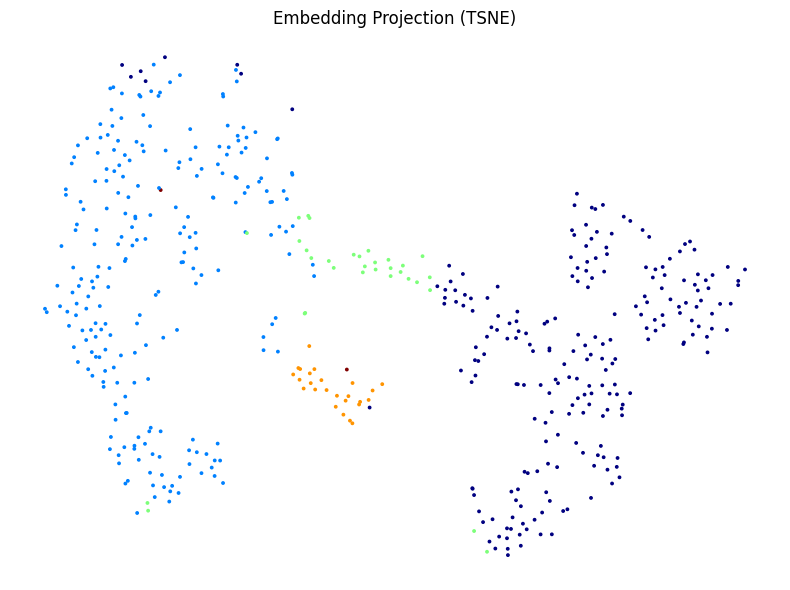

In [91]:
# Load a test point cloud
test_point_cloud = load_clean_point_cloud("data/roofNTNU/train_test_split/points_test/182371181-2.txt")  # Assuming XYZ format

# Run real-time inference & visualization
labels, embeddings = inference_on_point_cloud(model, test_point_cloud, device=device, clustering='meanshift')

# labels = filter_clusters(labels)

print("New predicted labels:", np.unique(labels))
visualize_embeddings(embeddings, labels, method='tsne')
visualize_clusters_plotly(test_point_cloud, labels)

In [17]:
print("Predicted label counts:", np.unique(labels, return_counts=True))
print("Embedding variance:", np.var(embeddings, axis=0).mean())

Predicted label counts: (array([-1]), array([512]))
Embedding variance: 0.35818487
